<a href="https://colab.research.google.com/github/deepnmr/ESTP/blob/main/hsqc_cs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulating NMR experiments

## NMR free induction decay (FID)
**One Dimensional FID**

NMR free induction decay (FID) is a summation of audio frequencies that spins speaks. :)

$$
FID(t) = \sum_{j=0}^{N-1} I_{j} exp(-2\pi * i * f_{H,j} * t) exp(-R_{2,H,j} * t)
$$

where $f_{H,j}$ is an individual spin ($j$) frequency, $R_{2,H,j}$ is $T_{2}$ relaxation rate of spin $j$.


* $^1H$ spectra usually have spectral widith 14 ppm. For simulatinng based on a 600 MHz machine , 14*600 = 8400 Hz. Water is on 4.8 ppm. So, center on water and between +/-4200 Hz.
- amide $^1H$ signals center on ~8.5 ppm. In the example, normal distribution is assumed.


## Generating 1D FID

In [ ]:
chemical_shifts = np.array([5,6,7]).astype('float32')
center_ppm = 4.8
MHz = 600
sw_ppm=14
TD = 2048
R2rate=5*np.pi*2

In [ ]:
def fid1D_generator_from_chemical_shift(chemical_shifts, center_ppm = 4.8, H_MHz=600,  sw_ppm=14, TD=2048, R2rate=10*np.pi*2):
  '''
  fid1D_generator_from_chemical_shifts
  making 1D FID 
  input = chemical_shifts, center_ppm, MHz,  sw_ppm, TD, R2rate
  chemical_shifts should be one dimensional arrary.
  It returns realfid, imaginaryfid
  '''
  # number of residue = number of peaks
  num_residue = len(chemical_shifts)

  # generating normal distribution around the give chemical shifts
  Hppm = np.random.normal(chemical_shifts, 0.05, num_residue)

  Hppmnorm = chemical_shifts

  Hppmnormoffseted = chemical_shifts - center_ppm

  # Now, ppm to frequency.

  Hfreq = Hppmnormoffseted*MHz

  ###### experimental-wise
  # spectral width in ppm to Hz
  sw_Hz = sw_ppm*MHz

  # spacing for measurement.
  dt = 1/sw_Hz

  # acquisition time
  # measuring real and imaginary, Thus, half.
  acq=dt*TD/2

  # time points
  time = np.linspace(0,acq,int(TD/2))

  # Relaxation 
  # how much? I don't know now. But, give choice.
  # I make an API for R2rate later.

  R2 = np.random.normal(R2rate,1,num_residue)

  ##########################################################
  ## Creating FID #####

  ## Real part #####
  fidreal = np.empty((num_residue,int(TD/2)))

  for i in range(len(Hfreq)):
    # cosine of frequency. So, real part
    fidindreal = np.cos(2*np.pi * Hfreq[i] * time)*np.exp(- R2[i] * time)
  
    # add random noise 2%
    fidindreal  = fidindreal + 0.02* (np.random.rand(1, int(TD/2)) - 0.5)

    fidreal[i,:] = fidindreal

  ## imaginary part #####
  fidimag = np.empty((num_residue,int(TD/2)))

  for i in range(len(Hfreq)):
    # sine part. So, imaginary part 
    fidindimag = np.sin(2*np.pi * Hfreq[i] * time)*np.exp(- R2[i] * time)
  
    # add random noise 2%
    fidindimag  = fidindimag + 0.02* (np.random.rand(1, int(TD/2)) - 0.5)

    fidimag[i,:] = fidindimag

  # summing up all residues
  fidreal = sum(fidreal)
  fidimag = sum(fidimag)

  return [fidreal, fidimag]

In [ ]:
fidreal, fidimag = fid1D_generator_from_chemical_shift(chemical_shifts)

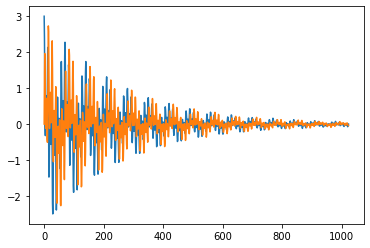

((1024,), (1024,))

In [ ]:
plt.plot(fidreal)
plt.plot(fidimag)
plt.show()

fidreal.shape,fidimag.shape

So, the 1D FID is generated. Let's check it give a right specturm.
In the example, 2 peaks are expected.

After having many issues, I found that complex numbers could not be maintained through the calculations.
I had to do with separting real and imaginary part, cosine and sine functions of exponential.

After make fast fourier transform using numpy fft. real of real and imaginary of imaginary had to be added for the frequency discrimination.

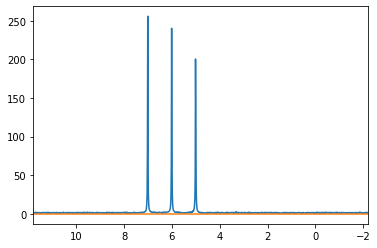

[5. 6. 7.]


In [ ]:
Hppmmin = 4.8 - 14/2
Hppmmax = 4.8 + 14/2

TDH = 2048

preal = np.fft.fft(fidreal)
pimag = np.fft.fft(fidimag)

spec = preal.real - pimag.imag

# Hppmmin to Hppmmax toward
# np.fft.fftshift
x = np.linspace(Hppmmin,Hppmmax,int(TDH/2))

specshift = np.fft.fftshift(spec)

plt.plot(x,specshift.real)
plt.plot(x,specshift.imag)
plt.xlim(Hppmmax,Hppmmin)
plt.show()

print(chemical_shifts)

## Generating a HSQC

**H,N correlation spectrum**

This could be heteronuclear single quantum correlation (HSQC) spectrum or heteronuclear multiple quantum correlation (HMQC) spectrum.

The spectra hav two frequencies (1H and 15N)

$$
FID(t_{1}, t_{2}) = \sum_{i=0}^{N-1} I_{i} * N_{s}(t_{1}) * H_{s}(t_{2})
$$

where

$$
N_{s}(t_{1}) = exp(-j * 2 \pi * Nfreq_{i} * t_{1}) * exp(-R_{2,N,i} * t_{1})
$$

$$
H_{s}(t_{2}) = \sum_{i}^{N} exp(-j * 2 \pi * Hfreq_{i} * t_{2}) * exp(-R_{2,H,i} * t_{2})
$$

$$
\delta t_{2} = \frac{1}{SW_{H}}
$$
$$
\delta t_{1} = \frac{1}{SW_{N}}
$$

* 15N is usally 100-140 ppm, gyromagnetic ratios $^1$H = 42.577, $^{15}$N = −4.316
- Also, amide nitrogen is centered on 120 ppm

In [ ]:
H_chemical_shifts = np.array([8.5,9,10]).astype('float32')
N_chemical_shifts = np.array([105,121,130]).astype('float32')
H_center_ppm = 4.8
N_center_ppm = 120
H_MHz = 600
H_sw_ppm=14
N_sw_ppm=40
H_TD=2048
N_TD=512
R2rate=10*np.pi*2

In [122]:
def HNHSQC_generator_from_chemical_shifts(H_chemical_shifts, N_chemical_shifts, H_center_ppm = 4.8, N_center_ppm =120, H_MHz=600,  H_sw_ppm=14, N_sw_ppm=40, H_TD=2048, N_TD=512, R2rate=5*np.pi*2):
  # number of residue = number of peaks = number of 1H frequency = number of 15N frequency
  assert len(H_chemical_shifts) == len(N_chemical_shifts), "lengths of H and N don't match"

  num_residue = len(H_chemical_shifts)

  # Generating Hppm normal distribution over 0.05 ppm
  Hppm = np.random.normal(H_chemical_shifts, 0.05, num_residue)

  # Generating Nppm normal distribution over 0.5 ppm
  Nppm = np.random.normal(N_chemical_shifts, 0.5, num_residue)

  # spectra measured normal on water (4.8 ppm) and Hppm on 8.5 ppm.
  Hppmn = Hppm - H_center_ppm

  # spectra measured normaly on 120 ppm.
  Nppmn = Nppm - N_center_ppm

  # Now, ppm to frequency.

  # gyromagnetic ratios:
  gH = 42.577
  gN = 4.316      # Important note: negative make fid grow. So, it should give as a positive.

  Hfreq = Hppmn * H_MHz
  Nfreq = Nppmn * H_MHz * gN / gH

  ###### experimental-wise
  # spectral width in ppm

  H_sw_Hz = H_sw_ppm * H_MHz
  N_sw_Hz = N_sw_ppm * H_MHz * gN / gH

  Hdt = 1 / H_sw_Hz
  Ndt = 1 / N_sw_Hz

  # equal spaced
  Hacq = Hdt * H_TD / 2
  Nacq = Ndt * N_TD / 2

  Htime = np.linspace(0, Hacq, int(H_TD / 2))
  Ntime = np.linspace(0, Nacq, int(N_TD / 2))

  ##########

  ##########
  # Relaxation
  # how much?

  R2 = np.random.normal(R2rate, 1, num_residue)


  ##########################################################
  ## Creating FID ##### 
  ## total four fids need
  ## HrealNreal, HimagNreal, HrealNimag, HimagNimag
  ##########################################################
  data = np.empty((int(H_TD / 2), int(N_TD * 2)))

  for j in range(len(Ntime)):
    ## H Real N Real part #####
    fidrealreal = np.empty((num_residue, int(H_TD / 2)))
    for i in range(len(Hfreq)):
      fidindreal = np.cos(2 * np.pi * Hfreq[i] * Htime) * np.exp(- R2[i] * time)
      fidindrealreal = fidindreal * np.cos(2 * np.pi * Nfreq[i] * Ntime[j]) * np.exp(-R2[i] * Ntime[j])

      # add random noise 2%
      fidindrealreal = fidindrealreal + 0.02 * (np.random.rand(1, int(H_TD / 2)) - 0.5)

      fidrealreal[i, :] = fidindrealreal

    ## H imag N Real part #####
    fidimagreal = np.empty((num_residue, int(H_TD / 2)))
    for i in range(len(Hfreq)):
      fidindimag = np.sin(2 * np.pi * Hfreq[i] * Htime) * np.exp(- R2[i] * Htime)
      fidindimagreal = fidindimag * np.cos(2 * np.pi * Nfreq[i] * Ntime[j]) * np.exp(-R2[i] * Ntime[j])

      # add random noise 2%
      fidindimagreal = fidindimagreal + 0.02 * (np.random.rand(1, int(H_TD / 2)) - 0.5)

      fidimagreal[i, :] = fidindimagreal

    ## H real N imag part #####
    fidrealimag = np.empty((num_residue, int(H_TD / 2)))
    for i in range(len(Hfreq)):
      fidindreal = np.cos(2 * np.pi * Hfreq[i] * Htime) * np.exp(- R2[i] * Htime)
      fidindrealimag = fidindreal * np.sin(2 * np.pi * Nfreq[i] * Ntime[j]) * np.exp(-R2[i] * Ntime[j])

      # add random noise 2%
      fidindrealimag = fidindrealimag + 0.02 * (np.random.rand(1, int(H_TD / 2)) - 0.5)

      fidrealimag[i, :] = fidindrealimag

    ## H imag N imag part #####
    fidimagimag = np.empty((num_residue, int(H_TD / 2)))
    for i in range(len(Hfreq)):
      fidindimag = np.sin(2 * np.pi * Hfreq[i] * Htime) * np.exp(- R2[i] * Htime)
      fidindimagimag = fidindimag * np.sin(2 * np.pi * Nfreq[i] * Ntime[j]) * np.exp(-R2[i] * Ntime[j])

      # add random noise 2%
      fidindimagimag = fidindimagimag + 0.02 * (np.random.rand(1, int(H_TD / 2)) - 0.5)

      fidimagimag[i, :] = fidindimagimag

    # summation over residues on a Ntime
    fidrealreal = sum(fidrealreal)
    fidimagreal = sum(fidimagreal)
    fidrealimag = sum(fidrealimag)
    fidimagimag = sum(fidimagimag)

    ################# Data structure #########################
    # Hreal[0] Nreal[0], Hreal[0] Nreal[1] .... Hreal[1] Nreal[254], Hreal[0] Nreal[255]
    # Himag[0] Nreal[0], Himag[0] Nreal[1] .... Himag[0] Nreal[254], Himag[0] Nimag[255]
    # Hreal[1] Nreal[0], Hreal[0] Nreal[1] .... Hreal[1] Nreal[254], Hreal[0] Nreal[255]
    # Himag[1] Nreal[0], Himag[0] Nreal[1] .... Himag[0] Nreal[254], Himag[0] Nimag[255]
    #      .
    #      .
    # Hreal[1023] Nreal[0]
    # Himag[1023] Nreal[0]

    data[:, 4 * j] = fidrealreal
    data[:, 4 * j + 1] = fidimagreal
    data[:, 4 * j + 2] = fidrealimag
    data[:, 4 * j + 3] = fidimagimag

##### Every second row column wuld be imaginary on H dimension

  return data


In [123]:
data = HNHSQC_generator_from_chemical_shifts(H_chemical_shifts, N_chemical_shifts, H_center_ppm = 4.8, N_center_ppm =120, H_MHz=600,  H_sw_ppm=14, N_sw_ppm=40, H_TD=2048, N_TD=512, R2rate=10*np.pi*2)

In [124]:
data.shape

(1024, 1024)

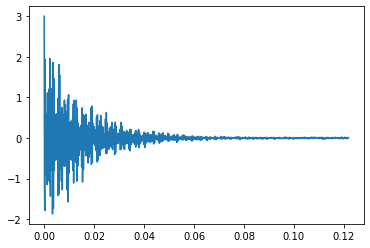

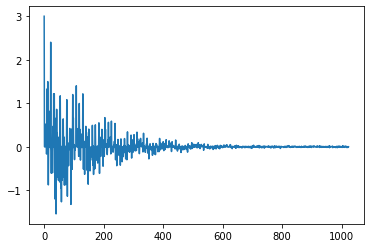

In [126]:
x=np.linspace(0,1/(14*600)*1024,1024)
plt.plot(x,data[:,0])
plt.show()

plt.plot(data[0,:])
plt.show()

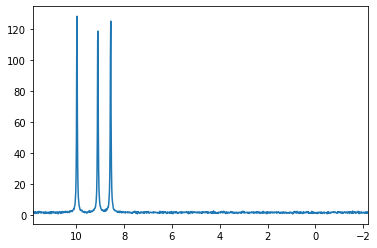

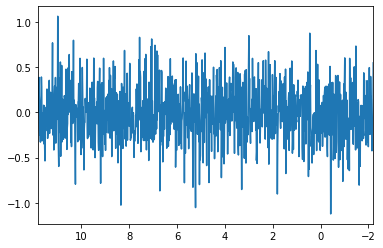

array([ 8.5,  9. , 10. ], dtype=float32)

In [127]:
xxx = np.fft.fftshift(np.fft.fft(data[:,0])).real - np.fft.fftshift(np.fft.fft(data[:,1])).imag
x = np.linspace(Hppmmin,Hppmmax,int(TDH/2))

plt.plot(x,xxx)
plt.xlim(Hppmmax,Hppmmin)
plt.show()

yyy = np.fft.fftshift(np.fft.fft(data[:,2])).real - np.fft.fftshift(np.fft.fft(data[:,3])).imag
x = np.linspace(Hppmmin,Hppmmax,int(TDH/2))

plt.plot(x,yyy)
plt.xlim(Hppmmax,Hppmmin)
plt.show()
H_chemical_shifts

In [128]:
!pip install nmrglue

In [129]:
import nmrglue as ng

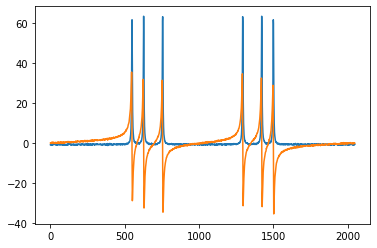

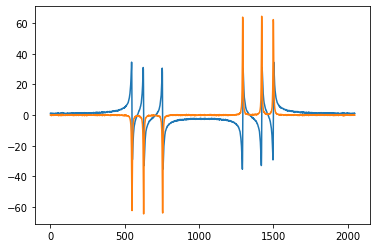

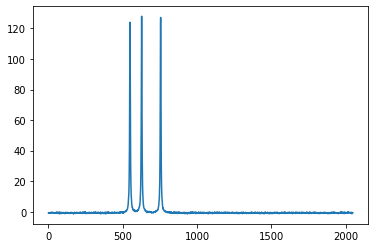

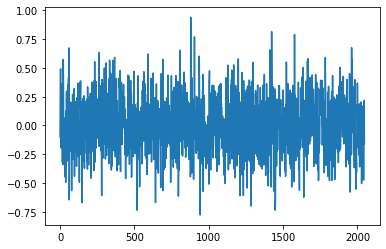

In [131]:
# data is HrealNreal, HimagNreal
#         HrealNimag, HimagNimag

# processing for H dimension
fidrealreal = data[:,0::4]
fidimagreal = data[:,1::4]


factor = 0.5
fidrealreal[0,:] = factor*fidrealreal[0,:]
fidimagreal[0,:] = factor*fidimagreal[0,:]

fidrealreal = fidrealreal.transpose()
fidimagreal = fidimagreal.transpose()

fidrealreal = ng.proc_base.sp(fidrealreal,off=0.5,end=0.95)
fidimagreal = ng.proc_base.sp(fidimagreal,off=0.5,end=0.95)

fidrealreal = ng.proc_base.zf(fidrealreal,1024)
fidimagreal = ng.proc_base.zf(fidimagreal,1024)

HrealFreal = np.fft.fft(fidrealreal)
HimagFreal = np.fft.fft(fidimagreal)

HrealFreal = HrealFreal.transpose()
HimagFreal = HimagFreal.transpose()

plt.plot(HrealFreal[:,0].real)
plt.plot(HrealFreal[:,0].imag)
plt.show()

plt.plot(HimagFreal[:,0].real)
plt.plot(HimagFreal[:,0].imag)
plt.show()

Freal = HrealFreal.real - HimagFreal.imag

plt.plot(Freal[:,0])
plt.show()

fidrealimag = data[:,2::4]
fidimagimag = data[:,3::4]

fidrealimag = fidrealimag.transpose()
fidimagimag = fidimagimag.transpose()

factor = 0.5
fidrealimag[:,0] = factor*fidrealimag[:,0]
fidimagimag[:,0] = factor*fidimagimag[:,0]

fidrealimag = ng.proc_base.sp(fidrealimag,off=0.5,end=0.95)
fidimagimag = ng.proc_base.sp(fidimagimag,off=0.5,end=0.95)

fidrealimag = ng.proc_base.zf(fidrealimag,int(H_TD/2))
fidimagimag = ng.proc_base.zf(fidimagimag,int(H_TD/2))

HrealFimag = np.fft.fft(fidrealimag)
HimagFimag = np.fft.fft(fidimagimag)

HrealFimag = HrealFimag.transpose()
HimagFimag = HimagFimag.transpose()

Fimag = HrealFimag.real - HimagFimag.imag

plt.plot(Fimag[:,0])
plt.show()

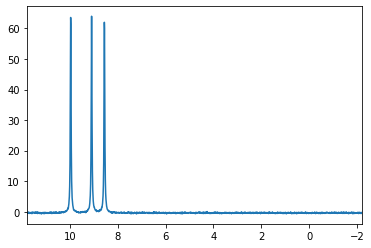

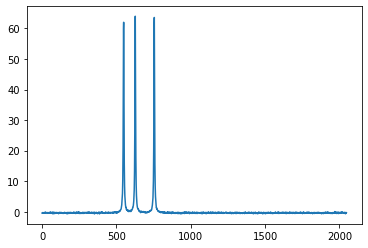

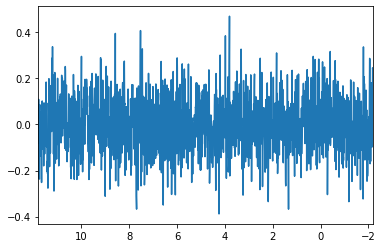

This is for checking N dimension: 627


In [139]:
x = np.linspace(Hppmmin,Hppmmax,int(TDH))
plt.plot(x,np.fft.fftshift(Freal[:,0]))
plt.xlim(Hppmmax,Hppmmin)
plt.show()

plt.plot(Freal[:,0])
plt.show()

plt.plot(x,Fimag[:,0])
plt.xlim(Hppmmax,Hppmmin)
plt.show()

print("This is for checking N dimension: " + str(np.argmax(Freal[:,0])))

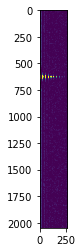

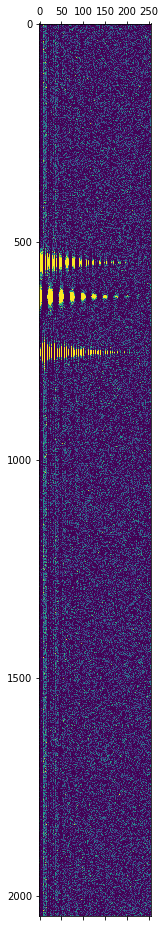

This is for checking N dimension: 627


In [138]:
plt.imshow(Freal,vmin=0, vmax=1)
plt.show()

plt.matshow(Freal,vmin=0,vmax=1)
plt.show()

print("This is for checking N dimension: " + str(np.argmax(Freal[:,0])))

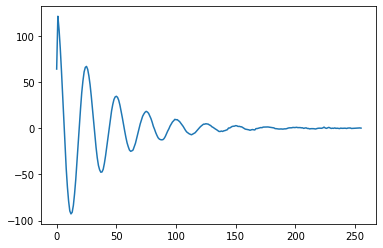

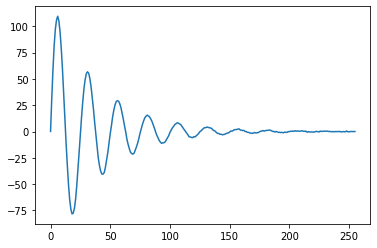

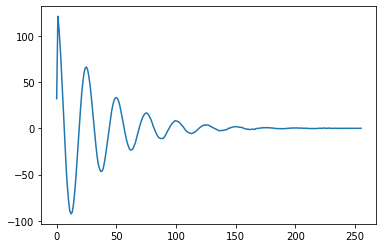

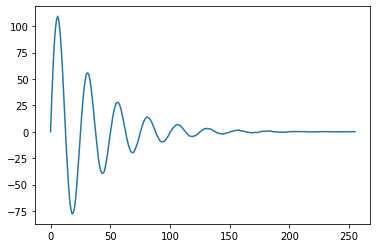

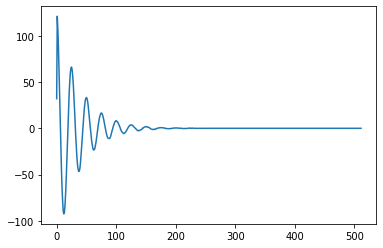

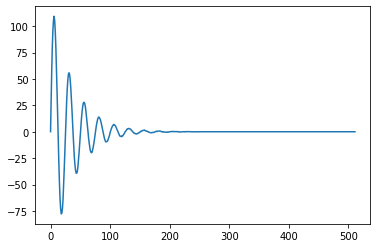

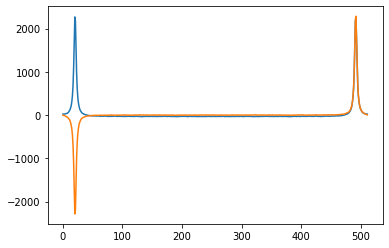

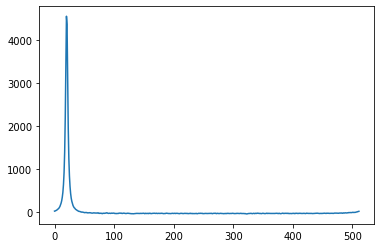

(2048, 512)

In [140]:
specreal = Freal
specimag = Fimag

Hmaxpoint = np.argmax(Freal[:,0])

plt.plot(specreal[Hmaxpoint,:])
plt.show()

plt.plot(specimag[Hmaxpoint,:])
plt.show()


factor = 0.5
specreal[:,0] = factor*specreal[:,0]
specimag[:,0] = factor*specimag[:,0]

specreal = ng.proc_base.sp(specreal,off=0.5,end=0.95)
specimag = ng.proc_base.sp(specimag,off=0.5,end=0.95)

plt.plot(specreal[Hmaxpoint,:])
plt.show()

plt.plot(specimag[Hmaxpoint,:])
plt.show()

specreal = ng.proc_base.zf(specreal,int(N_TD/2))
specimag = ng.proc_base.zf(specimag,int(N_TD/2))

plt.plot(specreal[Hmaxpoint,:])
plt.show()

plt.plot(specimag[Hmaxpoint,:])
plt.show()

specreal = np.fft.fft(specreal)
specimag = np.fft.fft(specimag)

plt.plot(specreal[Hmaxpoint,:].real)
plt.plot(specimag[Hmaxpoint,:].imag)
plt.show()

spec = specreal.real - specimag.imag

plt.plot(spec[Hmaxpoint,:])
plt.show()

spec.shape

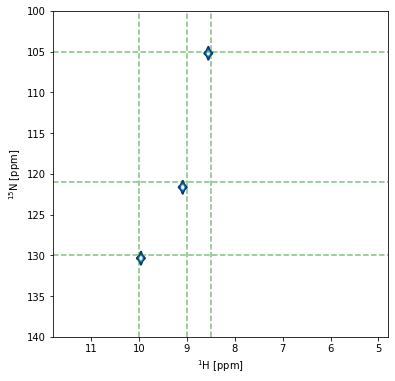

In [144]:
import matplotlib
Nppmmin = N_center_ppm - N_sw_ppm/2
Nppmmax = N_center_ppm + N_sw_ppm/2

specp = spec

specp = np.fft.fftshift(spec)

x = np.linspace(Hppmmin,Hppmmax,int(H_TD))
y = np.linspace(Nppmmin,Nppmmax,int(N_TD))

# plot parameters
cmap = matplotlib.cm.Blues_r        # contour map (colors to use for contours)

### contour parameters
contour_factor  = 1.4 # scaling factor between contour levels
contour_num     = 10  # number of contour levels

# To make max as the last contour level
# cs*cf^cn = max
# cs = max/(cf^cn)
contour_start   = np.max(specp)/(contour_factor**contour_num)  # contour level start value

# calculate contour levels
cl = contour_start * contour_factor ** np.arange(contour_num) 

plt.figure(figsize=(6,6))
for h_cs in H_chemical_shifts:
  plt.axvline(x=h_cs, color='g', linestyle='--',alpha=0.5)

for n_cs in N_chemical_shifts:
  plt.axhline(y=n_cs, color='g', linestyle='--',alpha=0.5)

plt.contour(x,y,specp.transpose(),levels = cl,cmap=cmap)
plt.xlim(Hppmmax,4.8)
plt.ylim(Nppmmax,Nppmmin)
plt.xlabel("$^1$H [ppm]")
plt.ylabel("$^{15}$N [ppm]")
plt.show()

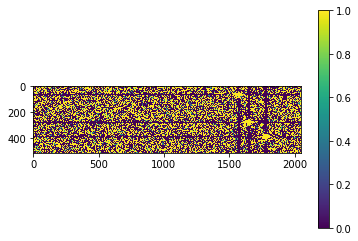

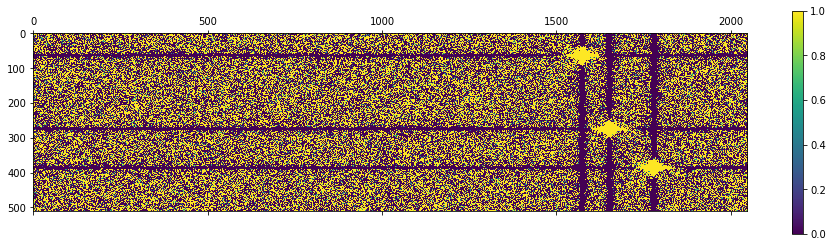

In [145]:
color_map = plt.imshow(specp.transpose(),
                       interpolation='nearest',
                       vmin=0,vmax=1)
plt.colorbar()

plt.show()

plt.matshow(specp.transpose(),
            interpolation='nearest',
            vmin=0,vmax=1)
plt.colorbar()
plt.show()